In [1]:
import numpy as np
import pandas as pd
import os
import sys
from google.colab import drive
import matplotlib.pyplot as plt
import math
import itertools
import random
import seaborn as sns
# import package
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, leaders
from scipy.cluster import hierarchy
from scipy.sparse import csr_matrix
import networkx as nx
import seaborn as sns
import math

sc = StandardScaler()

sns.set_style("ticks")

sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
#mount google colab
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [3]:

# import source data

# source data
influenceFile = "/content/drive/MyDrive/Richard_FRL/Project Data/2021_ICM_Problem_D_Data/influence_data.csv"
fullFileRes = "/content/drive/MyDrive/Richard_FRL/Project Data/2021_ICM_Problem_D_Data/full_music_data.csv"
artistFile = "/content/drive/MyDrive/Richard_FRL/Project Data/2021_ICM_Problem_D_Data/data_by_artist.csv"

# read data
fullData = pd.read_csv(fullFileRes)
influenceData = pd.read_csv(influenceFile)
artistData = pd.read_csv(artistFile)


In [4]:
influenceData.columns

Index(['influencer_id', 'influencer_name', 'influencer_main_genre',
       'influencer_active_start', 'follower_id', 'follower_name',
       'follower_main_genre', 'follower_active_start'],
      dtype='object')

In [5]:
influenceData['influencer_active_start'].value_counts()

1960    12640
1970     7996
1950     6643
1980     6083
1990     3646
1940     2957
1930     2409
2000      376
2010       20
Name: influencer_active_start, dtype: int64

In [6]:
active_start = {'1930':1,'1940':2,'1950':3,'1960':4,'1970':5,'1980':6,'1990':7,'2000':8,'2010':9}

In [7]:

# const genre group

genre = {'Pop/Rock':0, 'R&B;':1, 'Country':2, 'Jazz':3, 'Vocal':4, 'Latin':5, 'Classical':6, 'Folk':7, 'International':8, 'Blues':9, 'Reggae':10, 'Electronic':11, 'Easy Listening':12, 'Stage & Screen':13, 'Religious': 14, 'Comedy/Spoken':15, 'New Age':16, 'Avant-Garde':17, "Children's": 18, 'Unknown': 19}

In [8]:
def cleanData(data):
    cleaned_data = data.drop_duplicates(keep='first',inplace=False).loc[:, ~data.columns.str.contains("^Unnamed")].dropna(axis=1,how='all').dropna(axis=0, how='any')
    return cleaned_data

In [9]:
# clean data

fullData = cleanData(fullData)
artistData = cleanData(artistData)


In [10]:
genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])
active_start_res = pd.DataFrame(index=artistData.index, columns=['active_start_year'])

for row_index, row in artistData['artist_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) | (influenceData['follower_id'] == row)]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]

for row_index, row in artistData['artist_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) | (influenceData['follower_id'] == row)]['influencer_active_start'])
    if _tem.shape[0] != 0:
        active_start_res['active_start_year'][row_index] = _tem.iloc[0]

artistData_concated = pd.concat([artistData,genre_res],axis=1)
artistData_concated = pd.concat([artistData_concated,active_start_res],axis=1)
#artistData_concated.to_csv('./artistData_concated.csv')

genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])
active_start_res = pd.DataFrame(index=artistData.index, columns=['active_start_year'])

In [11]:
for row_index, row in fullData['artists_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == eval(row)[0]) | (influenceData['follower_id'] == eval(row)[0])]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
        
fullData_concated = pd.concat([fullData,genre_res],axis=1)

In [12]:
artistData = artistData_concated
fullData = fullData_concated

fullData = cleanData(fullData)
artistData = cleanData(artistData)

In [13]:
artistData

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count,genre,active_start_year
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,0.020855,0.232106,0.049614,189179.9255,26.004383,1369,Vocal,1930
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,0.022647,0.242243,0.098216,162279.2672,26.614130,1104,Country,1950
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,0.013064,0.217727,0.062432,185131.4530,15.621005,1095,Vocal,1930
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,0.034211,0.308978,0.064535,256713.4203,30.860806,1092,Pop/Rock,1960
5,The Rolling Stones,894465,0.524446,0.719915,0.655332,123.764717,-7.830265,1,0,0.293788,0.176137,0.268443,0.051440,229705.9623,34.573913,1035,Pop/Rock,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,Natalie La Rose,3359519,0.830000,0.520000,0.735000,104.990000,-8.714000,1,0,0.000792,0.000013,0.065600,0.037600,189907.0000,64.000000,1,R&B;,1970
5850,Sarah Ross,3381566,0.721000,0.944000,0.626000,85.002000,-5.982000,1,8,0.013000,0.000000,0.320000,0.159000,262760.0000,52.000000,1,Country,1930
5851,Rotimi,3410250,0.637000,0.501000,0.431000,103.993000,-6.148000,0,0,0.229000,0.000059,0.099000,0.187000,185461.0000,71.000000,1,R&B;,2000
5852,Jillian Jacqueline,3455945,0.547000,0.672000,0.283000,155.791000,-5.023000,1,11,0.304000,0.000000,0.099600,0.049600,213133.0000,58.000000,1,Country,1950


In [14]:
artistData['artist_name'].value_counts()

Prince           3
The Outsiders    3
Bill Evans       3
X                2
M.I.A.           2
                ..
ThalÃ­a          1
Whitesnake       1
Belly            1
Chris Knight     1
Mark Harris      1
Name: artist_name, Length: 5567, dtype: int64

         genre active_start_year  popul_by_genre
0        Vocal              1930       23.199897
2      Country              1950       34.167854
3        Vocal              1930       23.199897
4     Pop/Rock              1960       39.051741
5     Pop/Rock              1960       39.051741
...        ...               ...             ...
5849      R&B;              1970       42.768250
5850   Country              1930       23.941411
5851      R&B;              2000       55.926793
5852   Country              1950       34.167854
5853  Pop/Rock              2000       53.565912

[5602 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


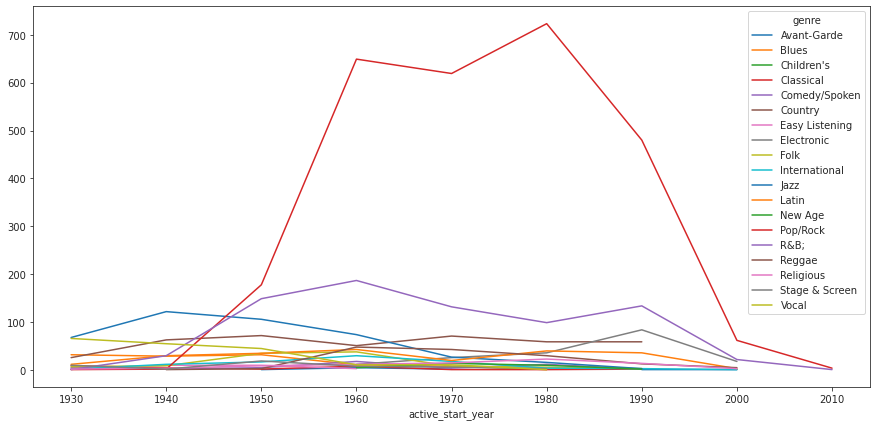

In [15]:
artistData['popul_by_artist_genre'] = artistData.groupby(['artist_name','genre'])['popularity'].transform('mean') 
artistData_plots = artistData[['genre','active_start_year','popul_by_artist_genre']]
artistData_plots['popul_by_genre'] = artistData_plots.groupby(['genre','active_start_year'])['popul_by_artist_genre'].transform('mean') 
del artistData_plots['popul_by_artist_genre'] 

print(artistData_plots)

fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
artistData_plots.groupby(['active_start_year','genre']).count()['popul_by_genre'].unstack().plot(ax=ax)

In [16]:
fullData

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,"[""Fat Freddy's Drop""]",[178301],0.600,0.365,0.131,130.046,-13.083,0.0,9.0,0.06720,0.585000,0.0921,0.0498,0.0,437200.0,54.0,2005.0,2005,Ernie,Electronic
1,"[""Fat Freddy's Drop""]",[178301],0.874,0.326,0.179,119.620,-13.302,0.0,11.0,0.01360,0.148000,0.0993,0.1310,0.0,581008.0,53.0,2005.0,2005,Wandering Eye,Electronic
2,"[""Fat Freddy's Drop""]",[178301],0.670,0.531,0.336,139.385,-8.267,0.0,9.0,0.01560,0.345000,0.3060,0.0377,0.0,431293.0,55.0,2009.0,8/7/2009,The Raft,Electronic
3,"[""Alexander O'Neal""]",[625201],0.761,0.702,0.850,104.773,-8.523,1.0,7.0,0.10800,0.000031,0.0935,0.0389,0.0,304427.0,34.0,1991.0,1/1/1991,All True Man,R&B;
4,"[""Alexander O'Neal""]",[625201],0.661,0.828,0.902,115.078,-12.673,0.0,11.0,0.27600,0.000001,0.2870,0.0390,0.0,264933.0,37.0,1987.0,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,['Aerosmith'],[604852],0.324,0.869,0.323,127.908,-10.112,1.0,7.0,0.13100,0.112000,0.7580,0.0620,0.0,265293.0,22.0,1978.0,10/1/1978,Back in the Saddle - Live at Market Square Are...,Pop/Rock
5850,['Aerosmith'],[604852],0.371,0.904,0.569,95.850,-9.861,1.0,2.0,0.01000,0.000012,0.2050,0.0546,0.0,221040.0,24.0,1985.0,1/1/1985,The Hop,Pop/Rock
5851,['Aerosmith'],[604852],0.317,0.746,0.244,119.216,-9.929,0.0,5.0,0.10800,0.000000,0.1720,0.0600,0.0,223600.0,24.0,1985.0,1/1/1985,Darkness,Pop/Rock
5852,['Aerosmith'],[604852],0.752,0.830,0.923,105.793,-3.291,0.0,6.0,0.01650,0.000032,0.0691,0.0550,0.0,309200.0,21.0,1986.0,5/15/1986,Walk This Way (feat. Aerosmith),Pop/Rock


# INSIGHTS + 

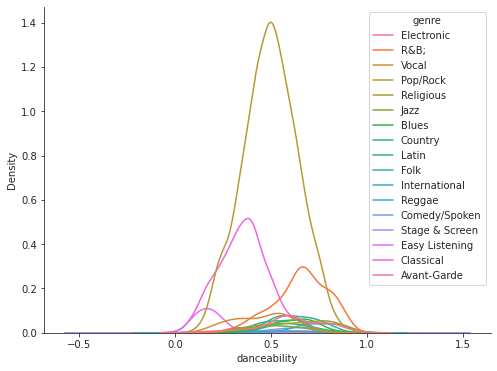

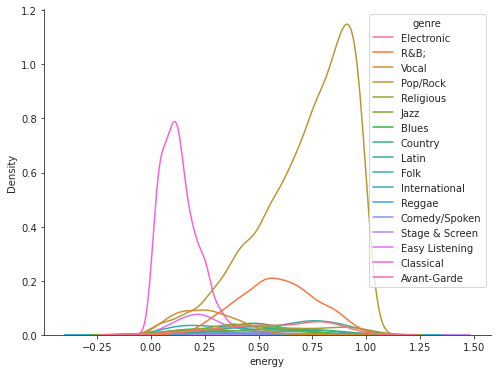

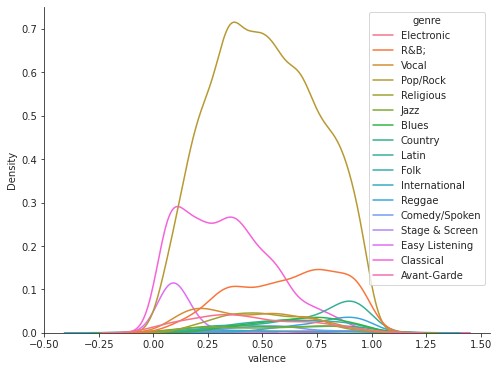

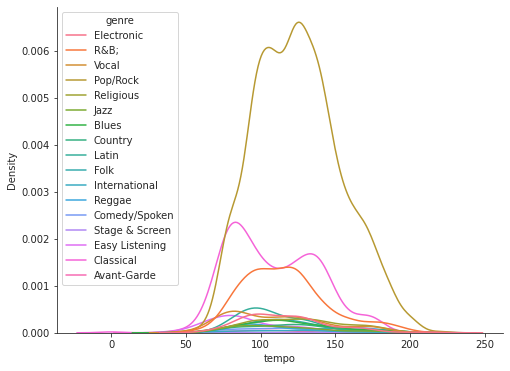

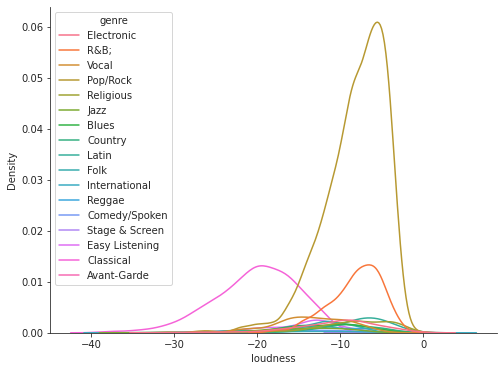

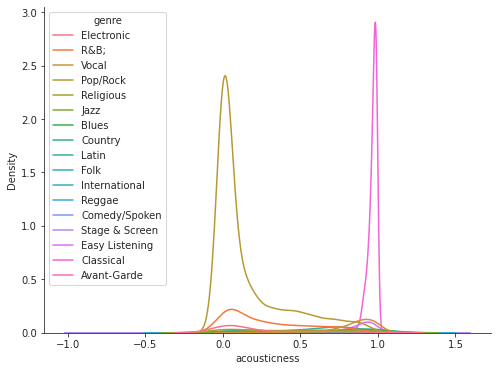

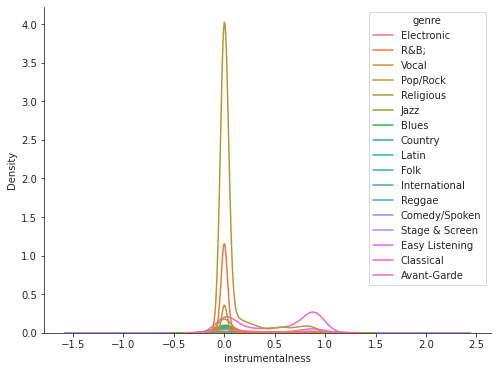

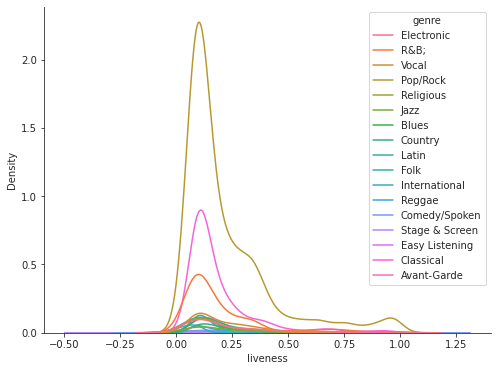

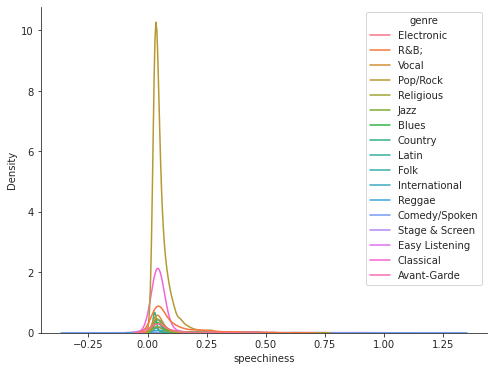

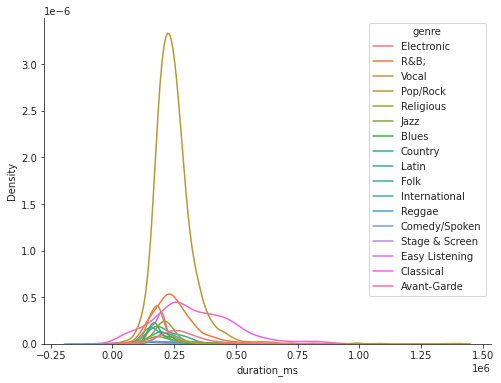

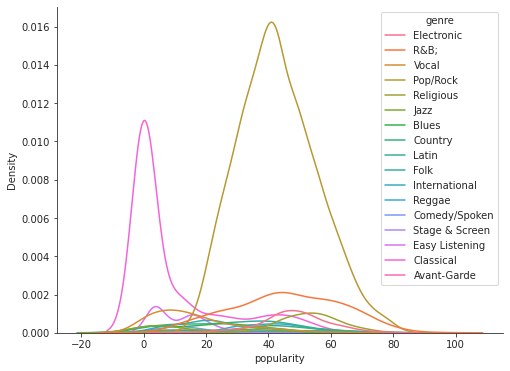

In [17]:
fullData['danceability'] = fullData['danceability'].astype('float')

plt.figure(figsize=(8, 6))


sns.kdeplot(
   data=fullData, x='danceability', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.2, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/danceability.jpg', dpi=600)

plt.figure(figsize=(8, 6))

fullData['energy'] = fullData['energy'].astype('float')


sns.kdeplot(

   data=fullData, x='energy', hue='genre',
#     fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/energy.jpg', dpi=600)

fullData['valence'] = fullData['valence'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='valence', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/valence.jpg', dpi=600)

fullData['tempo'] = fullData['tempo'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='tempo', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/tempo.jpg', dpi=600)


fullData['loudness'] = fullData['loudness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='loudness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/loudness.jpg', dpi=600)

fullData['acousticness'] = fullData['acousticness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='acousticness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/acousticness.jpg', dpi=600)

fullData['instrumentalness'] = fullData['instrumentalness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='instrumentalness', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/instrumentalness.jpg', dpi=600)

fullData['liveness'] = fullData['liveness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='liveness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/liveness.jpg', dpi=600)

fullData['speechiness'] = fullData['speechiness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='speechiness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/speechiness.jpg', dpi=600)

fullData['duration_ms'] = fullData['duration_ms'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='duration_ms', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/duration_ms.jpg', dpi=600)

fullData['popularity'] = fullData['popularity'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData, x='popularity', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('/content/sample_data/popularity.jpg', dpi=600)


# VIZs

         genre active_start_year  popul_by_genre
0        Vocal              1930       23.199897
2      Country              1950       34.167854
3        Vocal              1930       23.199897
4     Pop/Rock              1960       39.051741
5     Pop/Rock              1960       39.051741
...        ...               ...             ...
5849      R&B;              1970       42.768250
5850   Country              1930       23.941411
5851      R&B;              2000       55.926793
5852   Country              1950       34.167854
5853  Pop/Rock              2000       53.565912

[5602 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


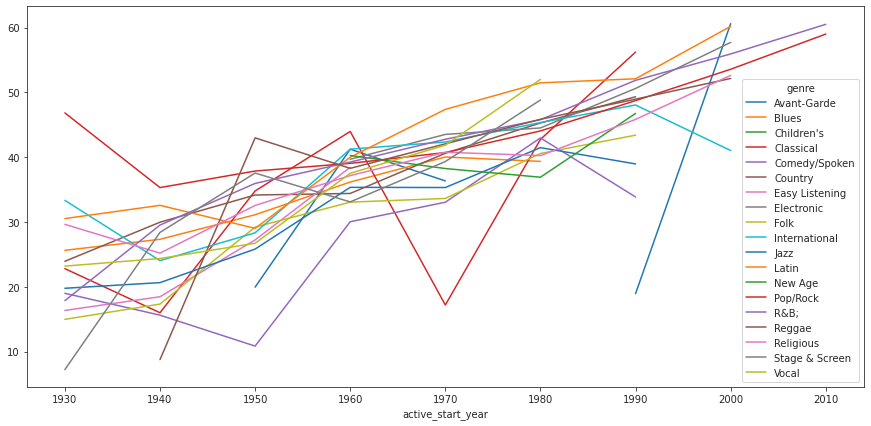

In [18]:

artistData['popul_by_artist_genre'] = artistData.groupby(['artist_name','genre'])['popularity'].transform('mean') 
artistData_plots = artistData[['genre','active_start_year','popul_by_artist_genre']]
artistData_plots['popul_by_genre'] = artistData_plots.groupby(['genre','active_start_year'])['popul_by_artist_genre'].transform('mean') 
del artistData_plots['popul_by_artist_genre'] 

print(artistData_plots)

fig, ax = plt.subplots(figsize=(15,7))
# use unstack()

artistData_plots.groupby(['active_start_year','genre']).mean()['popul_by_genre'].unstack().plot(ax=ax)

In [19]:
fullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5695 entries, 0 to 5853
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   artist_names           5695 non-null   object 
 1   artists_id             5695 non-null   object 
 2   danceability           5695 non-null   float64
 3   energy                 5695 non-null   float64
 4   valence                5695 non-null   float64
 5   tempo                  5695 non-null   float64
 6   loudness               5695 non-null   float64
 7   mode                   5695 non-null   float64
 8   key                    5695 non-null   float64
 9   acousticness           5695 non-null   float64
 10  instrumentalness       5695 non-null   float64
 11  liveness               5695 non-null   float64
 12  speechiness            5695 non-null   float64
 13  explicit               5695 non-null   float64
 14  duration_ms            5695 non-null   float64
 15  popu

In [20]:
fullData['year']

0       2005.0
1       2005.0
2       2009.0
3       1991.0
4       1987.0
         ...  
5849    1978.0
5850    1985.0
5851    1985.0
5852    1986.0
5853    1994.0
Name: year, Length: 5695, dtype: float64

In [21]:
fullData['year'] = pd.cut(fullData['year'], bins=[1910, 1920, 1930, 1940, 1950,1960,1970,1980,1990,2000,2010,2020])

           genre          year  popul_by_genre
0     Electronic  (2000, 2010]       50.802083
1     Electronic  (2000, 2010]       50.802083
2     Electronic  (2000, 2010]       50.802083
3           R&B;  (1990, 2000]       44.941520
4           R&B;  (1980, 1990]       36.686275
...          ...           ...             ...
5849    Pop/Rock  (1970, 1980]       38.124598
5850    Pop/Rock  (1980, 1990]       38.404190
5851    Pop/Rock  (1980, 1990]       38.404190
5852    Pop/Rock  (1980, 1990]       38.404190
5853    Pop/Rock  (1990, 2000]       45.335395

[5695 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


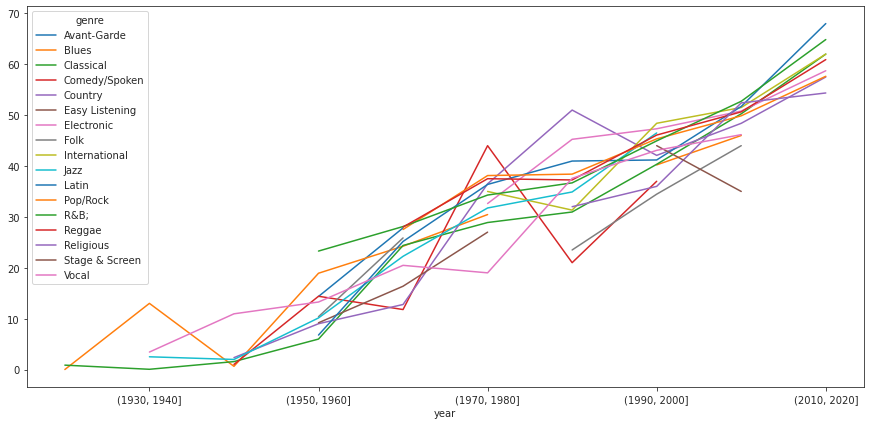

In [22]:
fullData['popul_by_song_genre'] = fullData.groupby(['song_title (censored)','genre'])['popularity'].transform('mean') 
fullData_plots = fullData[['genre','year','popul_by_song_genre']]
fullData_plots['popul_by_genre'] = fullData_plots.groupby(['genre','year'])['popul_by_song_genre'].transform('mean') 
del fullData_plots['popul_by_song_genre'] 

print(fullData_plots)

fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
fullData_plots.groupby(['year','genre']).mean()['popul_by_genre'].unstack().plot(ax=ax)